# import

In [1]:
import pandas as pd
import numpy as np
import os, sys, glob
from pathlib import Path
from scipy.interpolate import interp2d
from emgineer import EmgDecomposition, plot_spikes, plotly_spikes
import matplotlib.pyplot as plt

from statistics import median,variance,stdev
from scipy import stats
import math

import plotly.graph_objects as go
from calc_fr import st2fr, label_fr

from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score

sys.path.append('../load_intan_rhd_format')

from load_filt_test import read_data, guolv

def filt_all_rhd(path):
    rhd = read_data(path)
    array_emg = rhd['amplifier_data']
    array_emg = array_emg[:, 2000:]
    array_emg_filt = guolv(array_emg).T
    return array_emg_filt

def rms(x, axis=None):
    return np.sqrt(np.mean(x**2, axis=axis))

In [2]:
df_filename = pd.read_csv('table_filename.csv', index_col=0, header=0)
df_filename

,hashimoto,zhang,nakashima,li,tei
five_0,five_221217_164626,five_221220_133845,five_221220_150913,five_221221_142007,five_221222_145210
five_1,five_221217_171758,five_221220_134031,five_221220_151036,five_221221_142213,five_221222_145347
im_both_0,im_both_221217_173215,im_both_221220_141642,im_both_221220_153109,im_both_long_221220_153423,im_both_221222_151415
im_both_1,im_both_221217_174829,im_both_221220_141800,im_both_221220_153304,im_both_long_221220_153619,im_both_221222_152155
imrl_0,NaN,imrl_221220_143510,imrl_221220_154534,imrl_221221_144305,imrl_221222_153625
imrl_1,NaN,imrl_221220_143739,imrl_221220_154656,imrl_221221_144429,imrl_221222_153745


# labeling

In [378]:
# plotlyで可視化
subject_name = 'li'
motion_name = 'imrl'
motion_index = 1
path_root = glob.glob(f'G:/共有ドライブ/MFG/project/Biomedical engineering/Project プロジェクト/Bionic hand/EMG実験/2022*_{subject_name}')[0]
filename = df_filename[subject_name][motion_name + '_' + str(motion_index)]

path = f'{path_root}/{filename}/{filename}.rhd'
emg_filt = filt_all_rhd(path)
emg_flex = emg_filt[:, :64]

# param
n_motor_unit = 20

# decomp
print('start decomp')
est_flex = EmgDecomposition(
    n_motor_unit=n_motor_unit,
    n_delayed=8,
    random_state=0,
    cashe= os.path.basename(path_root)[9:] +'_' + filename + '_mu' + str(n_motor_unit),
    flag_sil=True,
    flag_pca=False)
est_flex.fit(emg_flex)
st_flex, mu_flex = est_flex.transform(emg_flex)

print('end decomp')
# plt.rcParams['figure.figsize'] = (12.0, 8.0)
# plot_spikes(st_flex[:, :20][:, ::-1], title='st_flex_expdata')
plotly_spikes(st_flex[:, :][:, ::-1])


Reading Intan Technologies RHD2000 Data File, Version 3.0

n signal groups 11
Found 128 amplifier channels.
Found 6 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 29.248 seconds of data.  Amplifiers were sampled at 2.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.5 seconds
start decomp
end decomp


## ラベル付けのための閾値とか決め

In [381]:
# labeling
df_st = pd.DataFrame(st_flex[:, :])
#df_st.iloc[:100, :] = 0
df_fr = st2fr(df_st, is_non_overlap=False)

go.Figure(go.Scatter(
    x=np.arange(768, len(df_fr)), 
    y=df_fr.sum(axis=1),
    )).show()

In [387]:
df_fr_labeled = label_fr(df_fr.copy(), n_repeat=3, min_fr=13)

go.Figure(go.Scatter(
    x=np.arange(len(df_fr_labeled)), 
    y=df_fr_labeled['label'],
    )).show()

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

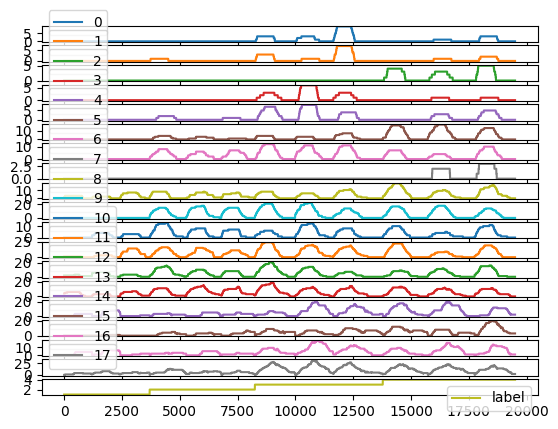

In [349]:
df_fr_labeled[df_fr_labeled['label'] > 0].dropna().reset_index(drop=True).plot(subplots=True)

In [388]:
# csv保存用のdf作成, 保存
dataset_name = f'fr_{motion_name}'

df_fr_csv = st2fr(pd.DataFrame(st_flex), is_non_overlap=False)
df_fr_csv['label'] = df_fr_labeled['label']
df_fr_csv.to_csv(f'{dataset_name}/fr_{subject_name}_{str(motion_index)}.csv', index=False)

# Classification

## SVC (decomposition method)

In [142]:
def cut_sample(X_train, X_test, label_train, label_test):
    _X_train = X_train[np.where(label_train != 0)[0], :]
    _X_test = X_test[np.where(label_test != 0)[0], :]
    _label_train = label_train[np.where(label_train != 0)[0]] -1
    _label_test = label_test[np.where(label_test != 0)[0]] -1
    return _X_train, _X_test, _label_train, _label_test

In [3]:
# flex のみ
dataset_name = 'fr_five'

subject_name = 'tei'
_path_root = glob.glob(f'G:/共有ドライブ/MFG/project/Biomedical engineering/Project プロジェクト/Bionic hand/EMG実験/2022*_{subject_name}')[0]
filename_train = df_filename[subject_name][dataset_name[3:] + '_0']
filename_test = df_filename[subject_name][dataset_name[3:] + '_1']

# load training data
df_fr_csv_train = pd.read_csv(f'{dataset_name}/fr_{subject_name}_0.csv', index_col=False, header=0)
fr_train = df_fr_csv_train.values[:, :-1]
label_train = df_fr_csv_train.values[:, -1].flatten()

path_train = f'{_path_root}/{filename_train}/{filename_train}.rhd'
emg_flex_train = filt_all_rhd(path_train)[:, :64]

# load test data
df_fr_csv_test = pd.read_csv(f'{dataset_name}/fr_{subject_name}_1.csv', index_col=False, header=0)
label_test = df_fr_csv_test.values[:, -1].flatten()

path_test = f'{_path_root}/{filename_test}/{filename_test}.rhd'
emg_flex_test = filt_all_rhd(path_test)[:, :64]

est_test = EmgDecomposition(
    n_motor_unit=20,
    n_delayed=8,
    random_state=0,
    cashe= f'{subject_name}_{filename_train}_mu20',
    flag_sil=True,
    flag_pca=False)

st_test, _ = est_test.fit_transform(emg_flex_test)
fr_test = st2fr(pd.DataFrame(st_test), is_non_overlap=False).values
print('end loading')
print(fr_train.shape, fr_test.shape, label_train.shape, label_test.shape)

#fr_train, fr_test, label_train, label_test = cut_sample(fr_train, fr_test, label_train, label_test)

# training
svm_clf = LinearSVC()
svm_clf.fit(fr_train, label_train)

# test
label_predicted = svm_clf.predict(fr_test)
print(accuracy_score(label_test, label_predicted))


Reading Intan Technologies RHD2000 Data File, Version 3.0

n signal groups 11
Found 128 amplifier channels.
Found 6 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 24.704 seconds of data.  Amplifiers were sampled at 2.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.3 seconds

Reading Intan Technologies RHD2000 Data File, Version 3.0

n signal groups 11
Found 128 amplifier channels.
Found 6 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 25.024 seconds of data. 

c:\Users\naoki\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.figure()
plot_confusion_matrix(
        svm_clf,
        fr_test,
        label_test,
        display_labels=['0', '1', '2', '3', '4', '5'],
        cmap=plt.cm.Blues,
        normalize='pred',
    )

In [ ]:
pd.DataFrame(label_predicted).plot(subplots=True)

## SVC (conventional method (RMS))

In [ ]:
# flexのみ
def emg_rms(array_emg, n_roll=768, cut_off=7):
    return pd.DataFrame(array_emg).pow(2).rolling(n_roll).mean().apply(np.sqrt, raw=True).dropna()[:-cut_off].values

# calc RMS
rms_train = emg_rms(emg_flex_train)
rms_test = emg_rms(emg_flex_test)

# training
svm_rms = LinearSVC(max_iter=100)
svm_rms.fit(rms_train, label_train)

# test
label_rms_predicted = svm_rms.predict(rms_test)
print(accuracy_score(label_test, label_rms_predicted))

In [ ]:
plt.figure()
plot_confusion_matrix(
        svm_rms,
        rms_test,
        label_test,
        display_labels=['0', '1', '2', '3', '4'],
        cmap=plt.cm.Blues,
        normalize='pred',
    )

In [ ]:
pd.DataFrame(label_rms_predicted).plot(subplots=True)